In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import scipy
import os
from itertools import permutations
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from sklearn.linear_model import LinearRegression
import difflib
from moviepy.editor import *
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

c:\Users\Jorge\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### SVM or KNN decoding of supervised behavior labels

In [3]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

In [196]:
full_data = pd.read_pickle('.\\fully_labeled_traces_feats3_071924.pickle')
# region and indexing-related variables / functions
region_ids = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)',
    'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)',
    'VMH (E)', 'VMH (I)', 'PAG (E)', 'PAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)', 
    'PA (E)', 'PA (I)', 'NAc (DA)'] # populations
indices = {val: idx for idx, val in enumerate(region_ids)} # dictionary with IDs for remapping
animal_indices = {idx : val for idx, val in enumerate(animals)}

### Formatting behavior labels (aggro vs investigation)

a. Binary labels must be processed as usual.

b. Aggro cannot be investigation or vice verse, therefore labels in one must be filtered out in the other.

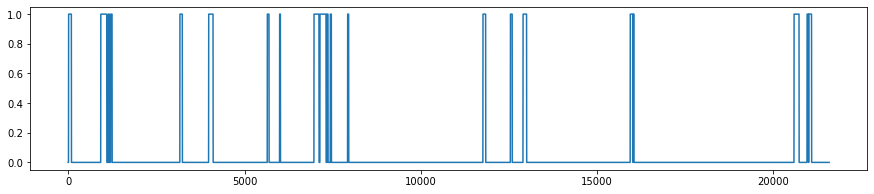

In [4]:
plt.figure(figsize=(15,3))
plt.plot(full_data['3095_d4_balbc_t3']['attack labels'])

In [438]:
def format4analysis(full_data, animal_ID, binary_labels='attack labels', beh='aggression'):

    sessions = list(full_data.keys())
    region_index, region_id = pd.factorize(region_ids)
    f = np.max([full_data[session].shape[0] for session in sessions])

    traces_lib = np.empty((f, len(region_index)+1, 27))
    traces_lib[:] = np.nan

    # package recordings into traces_lib array
    
    sessions2map = [x for x in sessions if animal_ID in x]
    if beh == 'aggression':
        sessions2map = [x for x in sessions2map if '_balbc_' in x or '_mCD1_' in x]
    elif beh == 'observation':
        sessions2map = [x for x in sessions2map if '_obs_' in x or '_OBSmCD1_' in x]
    else:
        sessions2map = [x for x in sessions2map if '_toy_' in x or '_toyCD1_' in x]

    for i, sesh in enumerate(sessions2map):

        # format traces from each session to fit the big nan array above
        s = full_data[sesh]
        if s.shape[0] < f:
            nan_pad = np.zeros((f-s.shape[0], s.shape[1]))
            nan_pad[:] = np.nan
            nan_pad = pd.DataFrame(nan_pad, columns=s.columns)
            s = pd.concat([s, nan_pad], axis=0)

        # copy columns at specific locations
        for idx, roi in zip(region_index, region_id):
            try: 
                traces_lib[:, idx, i] = s[roi]
            except KeyError:
                traces_lib[:, idx, i] = np.nan
        try:
            traces_lib[:, -1, i] = s[binary_labels]
        except KeyError:
            traces_lib[:, -1, i] = np.nan
        
    return traces_lib, s.columns

def produce_XY(epoch):
    
    epoch_df = pd.DataFrame()
    for i in range(epoch.shape[-1]):
        epoch_df = pd.concat([epoch_df, pd.DataFrame(epoch[:, :, i])])
    concat_sessions = epoch_df.to_numpy()
    filtered_sessions = concat_sessions[np.invert(np.isnan(concat_sessions[:, -1]))]

    X = filtered_sessions[:, :-1]
    orig_X = X.copy()
    if np.isnan(X).any(axis=0).any(): # remove columns with nan
        has_nan = np.isnan(X).any(axis=0)
        X = X[:, ~has_nan]
    y_init = filtered_sessions[:, -1]
    y = y_init.astype(int).reshape(-1,1)

    return X, y
    
def get_indices(partial_list):
    present_indices = [indices[val] for val in partial_list if val in indices]
    not_present = [val for val in np.arange(len(region_ids)) if val not in present_indices]
    return present_indices, not_present
    
def add_nan_values(matrix, rois, n_features=22):
    
    if len(rois) < n_features: 
        
        # Get roi indices
        pres_idxs, miss_idxs = get_indices(rois)
        # Create a copy of the original matrix to avoid modifying it
        matrix_copy = matrix.copy()
        # Create a 1D boolean mask that indicates where to add NaN values
        nan_mask = np.zeros(matrix_copy.shape[2], dtype=bool)
        print(miss_idxs)
        nan_mask[miss_idxs] = True
        # Add NaN values to the matrix
        matrix_copy = np.insert(matrix_copy, miss_idxs, np.nan, axis=2)
                
        return matrix_copy
    
    else:
        
        return matrix

def extract_events_of_interest(labels):
    events = []
    indices = []
    start_idx = None

    for i in range(len(labels)):
        if labels[i] == 1:
            if start_idx is None:
                start_idx = i
            indices.append(i)
        elif start_idx is not None:
            if len(indices) >= 8:
                events.append(indices)
            start_idx = None
            indices = []

    if start_idx is not None and len(indices) >= 1:
        events.append(np.asarray(indices))
    return events

def confidence(var):
    meanv = np.mean(var)
    semv = stats.sem(var)
    ci = 1.96 * semv
    return ci

def error_values(var, error_type='std'):
    if error_type == 'std':
        return np.nanstd(var)
    elif error_type == 'ci':
        return confidence(var.T)
    elif error_type == 'sem':
        return scipy.stats.sem(var.T)

### Running decoder on attacks

1. Prep data

In [7]:
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

def format4analysis(full_data, animal_ID, binary_labels='attack labels', exp='aggression'):

    sessions = list(full_data.keys())
    region_index, region_id = pd.factorize(region_ids)
    epochs = [[0, 3], [3, 6], [6, 9], [9, 12], [12, 15], [15, 18], [18, 21], [21,24], [24, 28]]
    f = np.max([full_data[session].shape[0] for session in sessions])

    traces_lib = np.empty((f, len(region_index)+1, 27))
    traces_lib[:] = np.nan

    # package recordings into traces_lib array

    if exp == 'aggression':
        sessions2map = [x for x in sessions if '_balbc_' in x or '_mCD1_' in x]
    elif exp == 'observation':
        sessions2map = [x for x in sessions if '_obs_' in x or '_OBSmCD1_' in x]
    else:
        sessions2map = [x for x in sessions if '_toy_' in x or '_toyCD1_' in x]

    for i, sesh in enumerate([x for x in sessions2map if animal_ID in x]):

        # format traces from each session to fit the big nan array above
        s = full_data[sesh]
        not_na_cols = s.columns[s.notna().all()].tolist()
        if s.shape[0] < f:
            nan_pad = np.zeros((f-s.shape[0], s.shape[1]))
            nan_pad[:] = np.nan
            nan_pad = pd.DataFrame(nan_pad, columns=s.columns)
            s = pd.concat([s, nan_pad], axis=0)

        # copy columns at specific locations
        for idx, roi in zip(region_index, region_id):
            try: 
                traces_lib[:, idx, i] = s[roi]
            except KeyError:
                traces_lib[:, idx, i] = np.nan
        traces_lib[:, -1, i] = s[binary_labels]

    # separate into epochs

    d1 = traces_lib[:, :, epochs[0][0]:epochs[0][1]]
    d2 = traces_lib[:, :, epochs[1][0]:epochs[1][1]]
    d3 = traces_lib[:, :, epochs[2][0]:epochs[2][1]]
    d4 = traces_lib[:, :, epochs[3][0]:epochs[3][1]]
    d5 = traces_lib[:, :, epochs[4][0]:epochs[4][1]]
    d6 = traces_lib[: ,:, epochs[5][0]:epochs[5][1]]
    d7 = traces_lib[: ,:, epochs[6][0]:epochs[6][1]]
    d8 = traces_lib[: ,:, epochs[7][0]:epochs[7][1]]
    d9 = traces_lib[: ,:, epochs[8][0]:epochs[8][1]]
    trial_comps = [d1, d2, d3, d4, d5, d6, d7, d8, d9] 

    return trial_comps, traces_lib, not_na_cols

def temporal_resample(X, y, window_size):

    data = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)

    # Separate the minority and majority classes
    minority_data = data[data.iloc[:, -1] == 1]
    majority_data = data[data.iloc[:, -1] == 0]

    # Calculate the number of samples to generate
    num_samples = len(majority_data) - len(minority_data)

    # Generate new samples
    new_samples = minority_data.sample(n=num_samples, replace=True, random_state=42)

    # Add the new samples to the original data
    resampled_data = pd.concat([majority_data, new_samples])

    # Sort the data by the time column to maintain temporal structure
    resampled_data = resampled_data.sort_index()

    # Separate resampled X and y
    X_resampled = resampled_data.iloc[:, :-1]
    y_resampled = resampled_data.iloc[:, -1]

    return X_resampled, y_resampled

2. Build and run decoders

In [8]:
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier

In [9]:
def run_KNN(new_data, animals, binary_labels):
    
    # For saving baseline scores
    grid_scores = np.zeros((9, len(animals)))
    held_out_scores = grid_scores.copy()
    
    shuffled_held_out_scores = grid_scores.copy()

    # For predicting on last BC
    late_scores = np.zeros((7, len(animals)))
    late_f1s = np.zeros((7, len(animals)))
    late_shuffled_held_out_scores = late_scores.copy()

    # For predicting on CD1
    cd1_scores = np.zeros((8, len(animals)))
    cd1_f1s = np.zeros((8, len(animals)))
    
    cd1_shuffled_held_out_scores = cd1_scores.copy()

    for a, animal in enumerate(animals):

        print('Processing data for %s' % animal)

        if a <= 11:
            exp='aggression'
        elif a<=18:
            exp='observation'
        else:
            exp='nonsocial'

        # load animal data
        trial_comps, _, rois = format4analysis(new_data, animal, binary_labels=binary_labels, exp=exp)
        rois = rois[:-3]

        for e, epoch in enumerate(trial_comps):

            print('Beginning epoch %i for animal %s' % (e, animal))

            # Divide data into inputs and outputs
            X, y = produce_XY(epoch)

            # Perform random undersampling to balance the classes
            rus = RandomUnderSampler(random_state=42)
            X_resampled, y_resampled = rus.fit_resample(X, y)

            # Create a KNN classifier
            knn_classifier = KNeighborsClassifier()

            # Define a grid of hyperparameters to search
            param_grid = {
                'n_neighbors': [3, 5, 7],  # Adjust the values of k as needed
                'weights': ['uniform', 'distance'],  # Weighting strategy
                'metric': ['euclidean', 'manhattan']  # Distance metric
            }


            # Create a GridSearchCV object with balanced accuracy as the scoring metric
            grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)

            # Perform the grid search on your data
            grid_search.fit(X_resampled, y_resampled)
            best_model = grid_search.best_estimator_

            # Print the best parameters and best balanced accuracy score
            print("Best Parameters (XVAL):", grid_search.best_params_)
            score = grid_search.best_score_
            grid_scores[e, a] = score
            print("Best Balanced Accuracy (XVAL):", score)

            # Print scores on shuffled set
            grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)
            X_shuf = X_resampled.copy()
            np.random.shuffle(X_shuf)
            grid_search.fit(X_shuf, y_resampled)
            score = grid_search.best_score_
            print("Best Shuffled Accuracy (XVAL):", score)
            shuffled_held_out_scores[e, a] = score

            if e in [0, 1, 2, 3, 4, 5, 6]:
                # Print scores using late held out set
                X_late, y_late = produce_XY(trial_comps[-2])
                y_pred = best_model.predict(X_late)
                score = balanced_accuracy_score(y_late, y_pred)
                late_scores[e, a] = score
                print("Best Balanced Accuracy (late):", score)
                score = f1_score(y_late, y_pred, average='weighted')
                late_f1s[e, a] = score
                print("Best F1 score (late):", score)
                
                # Print scores on shuffled set
                X_late_shuf = X_late.copy()
                np.random.shuffle(X_late_shuf)
                y_pred = best_model.predict(X_late_shuf)
                score = balanced_accuracy_score(y_late, y_pred)
                late_shuffled_held_out_scores[e, a] = score

            if e != 8:
                # Print scores using CD1 held out set
                X_cd1, y_cd1 = produce_XY(trial_comps[-1])
                y_pred = best_model.predict(X_cd1)
                score = balanced_accuracy_score(y_cd1, y_pred)
                cd1_scores[e, a] = score
                print("Best Balanced Accuracy (cd1):", score)
                score = f1_score(y_cd1, y_pred, average='weighted')
                cd1_f1s[e, a] = score
                print("Best F1 score (cd1):", score)
                
                # Print scores on shuffled set
                X_cd1_shuf = X_cd1.copy()
                np.random.shuffle(X_cd1_shuf)
                y_pred = best_model.predict(X_cd1_shuf)
                score = balanced_accuracy_score(y_cd1, y_pred)
                cd1_shuffled_held_out_scores[e, a] = score
                
    return grid_scores, shuffled_held_out_scores, late_scores, late_f1s, late_shuffled_held_out_scores, cd1_scores, cd1_f1s, cd1_shuffled_held_out_scores

grid_scores, shuffled_held_out_scores, late_scores, late_f1s, late_shuffled_held_out_scores, cd1_scores, cd1_f1s, cd1_shuffled_held_out_scores = run_KNN(full_data, animals, 'aggression labels') # aggro experience


Processing data for 3095
Beginning epoch 0 for animal 3095
Best Parameters (XVAL): {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best Balanced Accuracy (XVAL): 0.6754897295582519
Best Shuffled Accuracy (XVAL): 0.5313847862027733
Best Balanced Accuracy (late): 0.5260692266449616
Best F1 score (late): 0.8070173628009873
Best Balanced Accuracy (cd1): 0.4951422343568014
Best F1 score (cd1): 0.8810940724517671
Beginning epoch 1 for animal 3095
Best Parameters (XVAL): {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Balanced Accuracy (XVAL): 0.6434873093951555
Best Shuffled Accuracy (XVAL): 0.5022940168599487
Best Balanced Accuracy (late): 0.5922961477250342
Best F1 score (late): 0.864137840725285
Best Balanced Accuracy (cd1): 0.7268600400165847
Best F1 score (cd1): 0.9262096400581735
Beginning epoch 2 for animal 3095
Best Parameters (XVAL): {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best Balanced Accuracy (XVAL): 0.74207540874207

In [10]:
# define scores for each group

agg_grid_scores, agg_shuffled_held_out_scores, agg_late_scores, agg_late_f1s, agg_late_shuffled_held_out_scores, agg_cd1_scores, agg_cd1_f1s, agg_cd1_shuffled_held_out_scores = grid_scores[:, :12], shuffled_held_out_scores[:, :12], late_scores[:, :12], late_f1s[:, :12], late_shuffled_held_out_scores[:, :12], cd1_scores[:, :12], cd1_f1s[:, :12], cd1_shuffled_held_out_scores[:, :12]
obs_grid_scores, obs_shuffled_held_out_scores, obs_late_scores, obs_late_f1s, obs_late_shuffled_held_out_scores, obs_cd1_scores, obs_cd1_f1s, obs_cd1_shuffled_held_out_scores = grid_scores[:, 12:19], shuffled_held_out_scores[:, 12:19], late_scores[:, 12:19], late_f1s[:, 12:19], late_shuffled_held_out_scores[:, 12:19], cd1_scores[:, 12:19], cd1_f1s[:, 12:19], cd1_shuffled_held_out_scores[:, 12:19]
non_grid_scores, non_shuffled_held_out_scores, non_late_scores, non_late_f1s, non_late_shuffled_held_out_scores, non_cd1_scores, non_cd1_f1s, non_cd1_shuffled_held_out_scores = grid_scores[:, 19:], shuffled_held_out_scores[:, 19:], late_scores[:, 19:], late_f1s[:, 19:], late_shuffled_held_out_scores[:, 19:], cd1_scores[:, 19:], cd1_f1s[:, 19:], cd1_shuffled_held_out_scores[:, 19:]

3. Plot and stats

Plotting with null distributions:

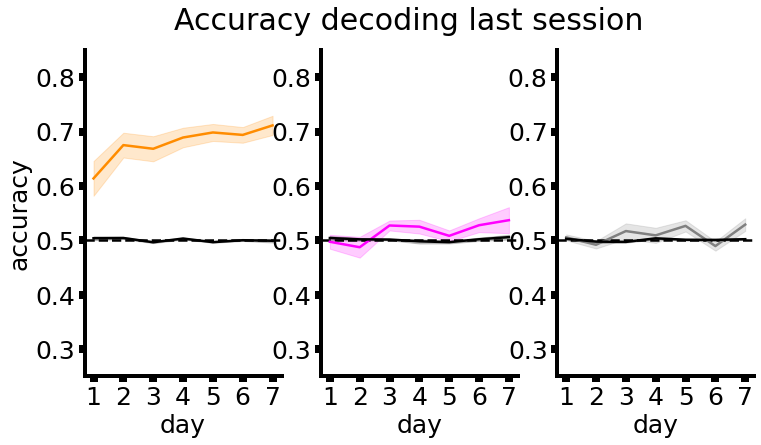

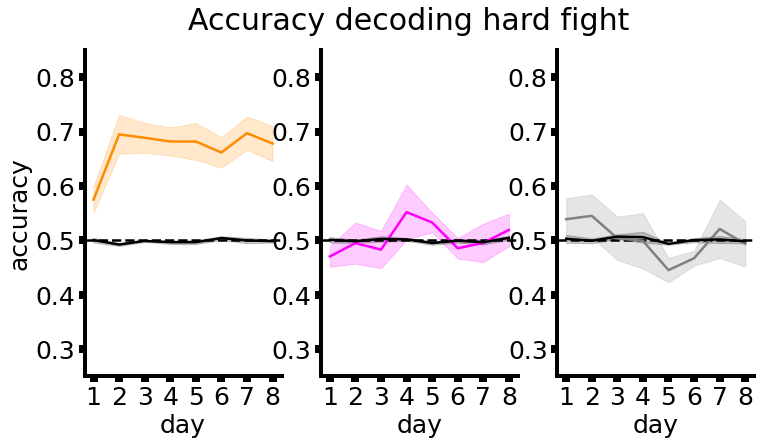

In [584]:
sns.set_context(rc={'lines.linewidth': 2.5,
              'axes.labelsize': 25,
              'axes.titlesize': 19.200000000000003,
              'font.size': 25,
              'xtick.major.width': 8,
              'ytick.major.width': 8,
              'xtick.major.size':6,
              'ytick.major.size':6,
              'axes.linewidth':4})
err='sem'
averaging=np.mean
agg_color='darkorange'
obs_color='magenta'
non_color='gray'
shuf_color='black'
### plot accuracies

###

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
n=7
sessions2exclude=None # 9 or -1
plt.suptitle('Accuracy decoding last session')
ax = ax.flatten()
for i, a in enumerate(ax):
    a.axhline(0.5, linestyle='--', color='black')
    a.set_xticks(np.arange(0, n))
    a.set_xticklabels(np.arange(1, n+1))
    a.set_ylim(top=0.85, bottom=0.25)
    a.set_xlabel('day')
    if i == 0:
         a.set_ylabel('accuracy')
varbs = [agg_late_scores, obs_late_scores, non_late_scores]
shuf_varbs = [agg_late_shuffled_held_out_scores, obs_late_shuffled_held_out_scores, non_late_shuffled_held_out_scores]
ax[0].plot(np.arange(n), averaging(varbs[0][:sessions2exclude], axis=1), color=agg_color, label='agg')
ax[0].fill_between(np.arange(n), averaging(varbs[0][:sessions2exclude], axis=1)+error_values(varbs[0][:sessions2exclude], err), averaging(varbs[0][:sessions2exclude], axis=1)-error_values(varbs[0][:sessions2exclude], err), 
           color=agg_color, alpha=0.2)
ax[0].plot(np.arange(n), averaging(shuf_varbs[0][:sessions2exclude], axis=1), color=shuf_color, label='agg shuffle')
ax[0].fill_between(np.arange(n), averaging(shuf_varbs[0][:sessions2exclude], axis=1)+error_values(shuf_varbs[0][:sessions2exclude], err), 
           averaging(shuf_varbs[0][:sessions2exclude], axis=1)-error_values(shuf_varbs[0][:sessions2exclude], err), color=shuf_color, alpha=0.2)

ax[1].plot(np.arange(n), averaging(varbs[1][:sessions2exclude], axis=1), color=obs_color, label='obs')
ax[1].fill_between(np.arange(n), averaging(varbs[1][:sessions2exclude], axis=1)+error_values(varbs[1][:sessions2exclude], err), averaging(varbs[1][:sessions2exclude], axis=1)-error_values(varbs[1][:sessions2exclude], err), 
                 color=obs_color, alpha=0.2)
ax[1].plot(np.arange(n), averaging(shuf_varbs[1][:sessions2exclude], axis=1), color=shuf_color, label='obs shuffle')
ax[1].fill_between(np.arange(n), averaging(shuf_varbs[1][:sessions2exclude], axis=1)+error_values(shuf_varbs[1][:sessions2exclude], err), 
           averaging(shuf_varbs[1][:sessions2exclude], axis=1)-error_values(shuf_varbs[1][:sessions2exclude], err), color=shuf_color, alpha=0.2)

ax[2].plot(np.arange(n), averaging(varbs[-1][:sessions2exclude], axis=1), color='gray', label='non')
ax[2].fill_between(np.arange(n), averaging(varbs[-1][:sessions2exclude], axis=1)+error_values(varbs[-1][:sessions2exclude], err),
                 averaging(varbs[-1][:sessions2exclude], axis=1)-error_values(varbs[-1][:sessions2exclude], err), color='gray', alpha=0.2)
ax[2].plot(np.arange(n), averaging(shuf_varbs[-1][:sessions2exclude], axis=1), color=shuf_color, label='non shuffle')
ax[2].fill_between(np.arange(n), averaging(shuf_varbs[-1][:sessions2exclude], axis=1)+error_values(shuf_varbs[-1][:sessions2exclude], err),
                 averaging(shuf_varbs[-1][:sessions2exclude], axis=1)-error_values(shuf_varbs[-1][:sessions2exclude], err), color=shuf_color, alpha=0.2)
sns.despine()
# plt.savefig('./figures/late_session_accuracy.svg', dpi=300)
###

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
n=8
sessions2exclude=None # 9 or -1
plt.suptitle('Accuracy decoding hard fight')
ax = ax.flatten()
for i, a in enumerate(ax):
    a.axhline(0.5, linestyle='--', color='black')
    a.set_xticks(np.arange(0, n))
    a.set_xticklabels(np.arange(1, n+1))
    a.set_ylim(top=0.85, bottom=0.25)
    a.set_xlabel('day')
    if i == 0:
         a.set_ylabel('accuracy')
varbs = [agg_cd1_scores, obs_cd1_scores, non_cd1_scores]
shuf_varbs = [agg_cd1_shuffled_held_out_scores, obs_cd1_shuffled_held_out_scores, non_cd1_shuffled_held_out_scores]
ax[0].plot(np.arange(n), averaging(varbs[0][:sessions2exclude], axis=1), color=agg_color, label='agg')
ax[0].fill_between(np.arange(n), averaging(varbs[0][:sessions2exclude], axis=1)+error_values(varbs[0][:sessions2exclude], err), averaging(varbs[0][:sessions2exclude], axis=1)-error_values(varbs[0][:sessions2exclude], err), 
           color=agg_color, alpha=0.2)
ax[0].plot(np.arange(n), averaging(shuf_varbs[0][:sessions2exclude], axis=1), color=shuf_color, label='agg shuffle')
ax[0].fill_between(np.arange(n), averaging(shuf_varbs[0][:sessions2exclude], axis=1)+error_values(shuf_varbs[0][:sessions2exclude], err), 
           averaging(shuf_varbs[0][:sessions2exclude], axis=1)-error_values(shuf_varbs[0][:sessions2exclude], err), color=shuf_color, alpha=0.2)

ax[1].plot(np.arange(n), averaging(varbs[1][:sessions2exclude], axis=1), color=obs_color, label='obs')
ax[1].fill_between(np.arange(n), averaging(varbs[1][:sessions2exclude], axis=1)+error_values(varbs[1][:sessions2exclude], err), averaging(varbs[1][:sessions2exclude], axis=1)-error_values(varbs[1][:sessions2exclude], err), 
                 color=obs_color, alpha=0.2)
ax[1].plot(np.arange(n), averaging(shuf_varbs[1][:sessions2exclude], axis=1), color=shuf_color, label='obs shuffle')
ax[1].fill_between(np.arange(n), averaging(shuf_varbs[1][:sessions2exclude], axis=1)+error_values(shuf_varbs[1][:sessions2exclude], err), 
           averaging(shuf_varbs[1][:sessions2exclude], axis=1)-error_values(shuf_varbs[1][:sessions2exclude], err), color=shuf_color, alpha=0.2)

ax[2].plot(np.arange(n), averaging(varbs[-1][:sessions2exclude], axis=1), color='gray', label='non')
ax[2].fill_between(np.arange(n), averaging(varbs[-1][:sessions2exclude], axis=1)+error_values(varbs[-1][:sessions2exclude], err),
                 averaging(varbs[-1][:sessions2exclude], axis=1)-error_values(varbs[-1][:sessions2exclude], err), color='gray', alpha=0.2)
ax[2].plot(np.arange(n), averaging(shuf_varbs[-1][:sessions2exclude], axis=1), color=shuf_color, label='non shuffle')
ax[2].fill_between(np.arange(n), averaging(shuf_varbs[-1][:sessions2exclude], axis=1)+error_values(shuf_varbs[-1][:sessions2exclude], err),
                 averaging(shuf_varbs[-1][:sessions2exclude], axis=1)-error_values(shuf_varbs[-1][:sessions2exclude], err), color=shuf_color, alpha=0.2)
sns.despine()
# plt.savefig('./figures/hard_fight_accuracy.svg', dpi=300)

Plotting using null distribution from NON decoding

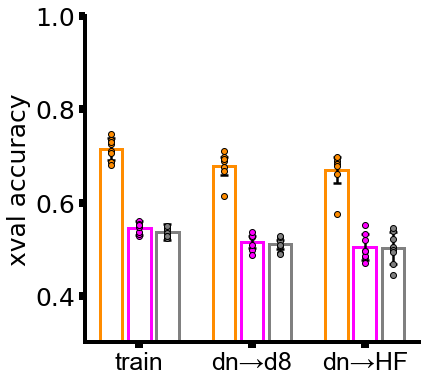

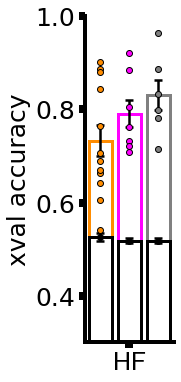

In [575]:
plt.figure(figsize=(6, 6))
# AGG
agg_color='darkorange'
obs_color='magenta'
non_color='gray'
shuf_color='black'
width_of_edge=3
bar_settings = {
    'color': 'white',
    'capsize': 2.5,
    'error_kw': {'elinewidth': 2.5, 'capsize': 4, 'capthick': 2.5}
}

mean_func = np.mean
plt.bar(0, mean_func(agg_grid_scores[:-1], axis=1).mean(), **bar_settings, yerr=np.std(agg_grid_scores[:-1], axis=1).mean()/np.sqrt(12), 
    edgecolor=agg_color, linewidth=width_of_edge, label='AGG')
plt.bar(1, mean_func(obs_grid_scores[:-1], axis=1).mean(), **bar_settings, yerr=np.std(obs_grid_scores[:-1], axis=1).mean()/np.sqrt(7), 
    edgecolor=obs_color, linewidth=width_of_edge, label='OBS')
plt.bar(2, mean_func(non_grid_scores[:-1], axis=1).mean(), **bar_settings, yerr=np.std(non_grid_scores[:-1], axis=1).mean()/np.sqrt(6), 
    edgecolor=non_color, linewidth=width_of_edge, label='NON')

plt.bar(4, mean_func(agg_late_scores, axis=1).mean(), **bar_settings, yerr=np.std(agg_late_scores, axis=1).mean()/np.sqrt(12), 
    edgecolor=agg_color, linewidth=width_of_edge)
plt.bar(5, mean_func(obs_late_scores, axis=1).mean(), **bar_settings, yerr=np.std(obs_late_scores, axis=1).mean()/np.sqrt(7),
       edgecolor=obs_color, linewidth=width_of_edge)
plt.bar(6, mean_func(non_late_scores, axis=1).mean(), **bar_settings, yerr=np.std(non_late_scores, axis=1).mean()/np.sqrt(6),
         edgecolor=non_color, linewidth=width_of_edge)

plt.bar(8, mean_func(agg_cd1_scores, axis=1).mean(), **bar_settings, yerr=np.std(agg_cd1_scores, axis=1).mean()/np.sqrt(12),
    edgecolor=agg_color, linewidth=width_of_edge)
plt.bar(9, mean_func(obs_cd1_scores, axis=1).mean(), **bar_settings, yerr=np.std(obs_cd1_scores, axis=1).mean()/np.sqrt(7),
         edgecolor=obs_color, linewidth=width_of_edge)
plt.bar(10, mean_func(non_cd1_scores, axis=1).mean(), **bar_settings, yerr=np.std(non_cd1_scores, axis=1).mean()/np.sqrt(6),
            edgecolor=non_color, linewidth=width_of_edge)

# Plot individual data points
plt.scatter(np.full_like(mean_func(agg_grid_scores[:-1], axis=1), 0), mean_func(agg_grid_scores[:-1], axis=1), color=agg_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(mean_func(obs_grid_scores[:-1], axis=1), 1), mean_func(obs_grid_scores[:-1], axis=1), color=obs_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(mean_func(non_grid_scores[:-1], axis=1), 2), mean_func(non_grid_scores[:-1], axis=1), color=non_color, edgecolor='black', zorder=2)

plt.scatter(np.full_like(mean_func(agg_late_scores, axis=1), 4), mean_func(agg_late_scores, axis=1), color=agg_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(mean_func(obs_late_scores, axis=1), 5), mean_func(obs_late_scores, axis=1), color=obs_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(mean_func(non_late_scores, axis=1), 6), mean_func(non_late_scores, axis=1), color=non_color, edgecolor='black', zorder=2)

plt.scatter(np.full_like(mean_func(agg_cd1_scores, axis=1), 8), mean_func(agg_cd1_scores, axis=1), color=agg_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(mean_func(obs_cd1_scores, axis=1), 9), mean_func(obs_cd1_scores, axis=1), color=obs_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(mean_func(non_cd1_scores, axis=1), 10), mean_func(non_cd1_scores, axis=1), color=non_color, edgecolor='black', zorder=2)

# Formatting
plt.ylabel('xval accuracy')
plt.ylim(bottom=0.3, top=1.0)
plt.xticks([1, 5, 9], ['train', 'dn→d8', 'dn→HF'], rotation=0, fontfamily='Arial')
sns.despine()
plt.savefig('./figures/xval_accuracy_summary.svg', dpi=300, bbox_inches='tight')

plt.figure(figsize=(1.6, 6))
plt.bar(0, mean_func(agg_grid_scores[-1]), **bar_settings, yerr=np.std(agg_grid_scores[-1])/np.sqrt(12),
    edgecolor=agg_color, linewidth=width_of_edge)
plt.bar(0, mean_func(agg_shuffled_held_out_scores[-1]), **bar_settings, yerr=np.std(agg_shuffled_held_out_scores[-1])/np.sqrt(12),
    edgecolor=shuf_color, linewidth=width_of_edge)
plt.bar(1, mean_func(obs_grid_scores[-1]), **bar_settings, yerr=np.std(obs_grid_scores[-1])/np.sqrt(7),
    edgecolor=obs_color, linewidth=width_of_edge)
plt.bar(1, mean_func(obs_shuffled_held_out_scores[-1]), **bar_settings, yerr=np.std(obs_shuffled_held_out_scores[-1])/np.sqrt(7),
    edgecolor=shuf_color, linewidth=width_of_edge)
plt.bar(2, mean_func(non_grid_scores[-1]), **bar_settings, yerr=np.std(non_grid_scores[-1])/np.sqrt(6),
    edgecolor=non_color, linewidth=width_of_edge)
plt.bar(2, mean_func(non_shuffled_held_out_scores[-1]), **bar_settings, yerr=np.std(non_shuffled_held_out_scores[-1])/np.sqrt(6),
    edgecolor=shuf_color, linewidth=width_of_edge)

plt.scatter(np.full_like(agg_grid_scores[-1], 0), agg_grid_scores[-1], color=agg_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(obs_grid_scores[-1], 1), obs_grid_scores[-1], color=obs_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(non_grid_scores[-1], 2), non_grid_scores[-1], color=non_color, edgecolor='black', zorder=2)

plt.scatter(np.full_like(mean_func(agg_shuffled_held_out_scores[-1]), 0), mean_func(agg_shuffled_held_out_scores[-1]), color=shuf_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(mean_func(obs_shuffled_held_out_scores[-1]), 1), mean_func(obs_shuffled_held_out_scores[-1]), color=shuf_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(mean_func(non_shuffled_held_out_scores[-1]), 2), mean_func(non_shuffled_held_out_scores[-1]), color=shuf_color, edgecolor='black', zorder=2)

plt.ylabel('xval accuracy')
plt.ylim(bottom=0.3, top=1.0)
plt.xticks([1], ['HF'], rotation=0, fontfamily='Arial')
sns.despine()
plt.savefig('./figures/xval_accuracy_summary_HF.svg', dpi=300, bbox_inches='tight')

In [536]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import shapiro, ttest_ind

# stats against null distribution models

mean_func = np.nanmedian
items2stat = [[mean_func(agg_grid_scores[:-1], axis=1), mean_func(non_grid_scores[:-1], axis=1)], 
              [mean_func(agg_late_scores, axis=1), mean_func(non_late_scores, axis=1)], 
              [mean_func(agg_cd1_scores, axis=1), mean_func(non_cd1_scores, axis=1)],
              [mean_func(obs_grid_scores[:-1], axis=1), mean_func(non_grid_scores[:-1], axis=1)],
              [mean_func(obs_late_scores, axis=1), mean_func(non_late_scores, axis=1)],
              [mean_func(obs_cd1_scores, axis=1), mean_func(non_cd1_scores, axis=1)],
              [agg_grid_scores[-1], agg_shuffled_held_out_scores[-1]],
              [obs_grid_scores[-1], obs_shuffled_held_out_scores[-1]],
              [non_grid_scores[-1], non_shuffled_held_out_scores[-1]]]

descs2stat = ['AGG: DAY', 'AGG: E2L', 'AGG: TP 2 HF', 'OBS: DAY', 'OBS: E2L', 'OBS: TP 2 HF', 
              'AGG: HF', 'OBS: HF', 'NON: HF']

p_values = []
test_types = []
t_values = []
for i, item in enumerate(items2stat):
    _, p1 = shapiro(item[0])
    _, p2 = shapiro(item[1])

    if p1 > 0.05 and p2 > 0.05:
        p_values.append(ttest_ind(item[0], item[1]).pvalue)
        t_values.append(ttest_ind(item[0], item[1]).statistic)
        test_types.append('t')
    else:
        p_values.append(stats.mannwhitneyu(item[0], item[1]).pvalue)
        t_values.append(stats.mannwhitneyu(item[0], item[1]).statistic)
        test_types.append('U')

rejected, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')
for p, pval in enumerate(corrected_p_values):
    print('Comparing %s' % descs2stat[p])
    if p <= 2:
        print('AGG vs NON; %s = %f, p = %f' % (test_types[p], t_values[p], pval))
    elif p <= 5:
        print('OBS vs NON; %s = %f, p = %f' % (test_types[p], t_values[p], pval))
    elif p == 6:
        print('AGG vs shuffle; %s = %f, p = %f' % (test_types[p], t_values[p], pval))
    elif p == 7:
        print('OBS vs shuffle; %s = %f, p = %f' % (test_types[p], t_values[p], pval))
    elif p == 8:
        print('NON vs shuffle; %s = %f, p = %f' % (test_types[p], t_values[p], pval))

Comparing AGG: DAY
AGG vs NON; t = 19.416186, p = 0.000000
Comparing AGG: E2L
AGG vs NON; t = 13.405998, p = 0.000000
Comparing AGG: TP 2 HF
AGG vs NON; t = 10.732263, p = 0.000000
Comparing OBS: DAY
OBS vs NON; t = 0.731368, p = 0.612795
Comparing OBS: E2L
OBS vs NON; t = 0.071565, p = 0.944127
Comparing OBS: TP 2 HF
OBS vs NON; t = 0.396371, p = 0.785033
Comparing AGG: HF
AGG vs shuffle; t = 5.758901, p = 0.000013
Comparing OBS: HF
OBS vs shuffle; t = 8.528477, p = 0.000004
Comparing NON: HF
NON vs shuffle; t = 8.718138, p = 0.000010


In [545]:
from statsmodels.regression.mixed_linear_model import MixedLM

###

data2stat = agg_grid_scores.copy()[:-1,:].T
df = pd.DataFrame({
    'Measurement': data2stat.flatten(),
    'Subject': np.concatenate([np.repeat(i, data2stat.shape[1]) for i in np.arange(12)]),
    'Time': np.concatenate([np.arange(data2stat.shape[1]) for i in np.arange(12)])
})

# Perform mixed linear model
model = MixedLM(df['Measurement'], df[['Time']], groups=df['Subject'])
res = model.fit()
print("Time effect for within-train:", res.pvalues['Time'])
print(res.tvalues['Time'])

###

data2stat = agg_late_scores.copy().T
df = pd.DataFrame({
    'Measurement': data2stat.flatten(),
    'Subject': np.concatenate([np.repeat(i, data2stat.shape[1]) for i in np.arange(12)]),
    'Time': np.concatenate([np.arange(data2stat.shape[1]) for i in np.arange(12)])
})

# Perform mixed linear model
model = MixedLM(df['Measurement'], df[['Time']], groups=df['Subject'])
res = model.fit()
print("Time effect for cross-train:", res.pvalues['Time'])
print(res.tvalues['Time'])

###

data2stat = agg_cd1_scores.copy().T
df = pd.DataFrame({
    'Measurement': data2stat.flatten(),
    'Subject': np.concatenate([np.repeat(i, data2stat.shape[1]) for i in np.arange(12)]),
    'Time': np.concatenate([np.arange(data2stat.shape[1]) for i in np.arange(12)])
})

# Perform mixed linear model
model = MixedLM(df['Measurement'], df[['Time']], groups=df['Subject'])
res = model.fit()
print("Time effect for train->HF:", res.pvalues['Time'])
print(res.tvalues['Time'])

Time effect for within-train: 0.5356984507724829
-0.6193308111707134
Time effect for cross-train: 1.100441539550618e-05
4.396433302432789
Time effect for train->HF: 0.019031535828647004
2.344912686552047


### Run decoder while performing feature importance

Feature importance testing done in circuit-wide manner (removing all E circuits vs removing all I circuits)

1. Implement and run

In [27]:
def extract_circuit_indices(current_regions):
    E_indices = [i for i, reg in enumerate(current_regions) if '(E)' in reg or '(DA)' in reg]
    I_indices = [i for i, reg in enumerate(current_regions) if '(I)' in reg or '(DA)' in reg]
    return E_indices, I_indices

def run_KNN_w_KOs(new_data, animals, binary_labels):
    
    '''
    same as function above but knocks out whole E vs I circuits
    '''
    
    # For saving baseline scores
    perm_grid_scores = np.zeros((9, 2, len(animals)))
    perm_grid_scores[:] = np.nan
    perm_held_out_scores = perm_grid_scores.copy()
    perm_shuffled_held_out_scores = perm_grid_scores.copy()

    # For predicting on last BC
    perm_late_scores = np.zeros((7, 2, len(animals)))
    perm_late_scores[:] = np.nan
    perm_late_f1s = np.zeros((7, 2, len(animals)))
    perm_late_f1s[:] = np.nan
    
    # For predicting on CD1
    perm_cd1_scores = np.zeros((8, 2, len(animals)))
    perm_cd1_scores[:] = np.nan
    perm_cd1_f1s = np.zeros((8, 2, len(animals)))
    perm_cd1_f1s[:] = np.nan

    for a, animal in enumerate(animals):

        print('Processing data for %s' % animal)

        if a <= 11:
            exp='aggression'
        elif a<=18:
            exp='observation'
        else:
            exp='nonsocial'

        # load animal data
        trial_comps, _, rois = format4analysis(new_data, animal, binary_labels=binary_labels, exp=exp)
        rois = rois[:-3]
        E_indices, I_indices = extract_circuit_indices(rois)
        print(E_indices, I_indices)

        for e, epoch in enumerate(trial_comps):

            print('Beginning epoch %i for animal %s' % (e, animal))

            # Divide data into inputs and outputs
            X, y = produce_XY(epoch)

            # Perform random undersampling to balance the classes
            rus = RandomUnderSampler(random_state=42)
            X_resampled, y_resampled = rus.fit_resample(X, y)
            
            for idx, n in enumerate([E_indices, I_indices]):
            
                # Do feature-dependent shuffle
                X_perm = X_resampled.copy()
                column_to_shuffle = X_perm[:, n]
                np.random.shuffle(column_to_shuffle)
                X_perm[:, n] = column_to_shuffle

                # Create a KNN classifier
                knn_classifier = KNeighborsClassifier()

                # Define a grid of hyperparameters to search
                param_grid = {
                    'n_neighbors': [3, 5, 7],  # Adjust the values of k as needed
                    'weights': ['uniform', 'distance'],  # Weighting strategy
                    'metric': ['euclidean', 'manhattan']  # Distance metric
                }


                # Create a GridSearchCV object with balanced accuracy as the scoring metric
                grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)

                # Perform the grid search on your data
                grid_search.fit(X_perm, y_resampled)
                best_model = grid_search.best_estimator_

                # Print the best parameters and best balanced accuracy score
                print("Best Parameters (XVAL):", grid_search.best_params_)
                score = grid_search.best_score_
                perm_grid_scores[e, idx, a] = score
                print("Best Balanced Accuracy (XVAL):", score)

                # Print scores on shuffled set
                grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=3)
                X_shuf = X_resampled.copy()
                np.random.shuffle(X_shuf)
                grid_search.fit(X_shuf, y_resampled)
                score = grid_search.best_score_
                print("Best Shuffled Accuracy (XVAL):", score)
                perm_shuffled_held_out_scores[e, idx, a] = score

                if e in [0, 1, 2, 3, 4, 5, 6]:
                    # Print scores using late held out set
                    X_late, y_late = produce_XY(trial_comps[-2])
                    y_pred = best_model.predict(X_late)
                    score = balanced_accuracy_score(y_late, y_pred)
                    perm_late_scores[e, idx, a] = score
                    print("Best Balanced Accuracy (late):", score)
                    score = f1_score(y_late, y_pred, average='weighted')
                    perm_late_f1s[e, idx, a] = score
                    print("Best F1 score (late):", score)

                if e != 8:
                    # Print scores using CD1 held out set
                    X_cd1, y_cd1 = produce_XY(trial_comps[-1])
                    y_pred = best_model.predict(X_cd1)
                    score = balanced_accuracy_score(y_cd1, y_pred)
                    perm_cd1_scores[e, idx, a] = score
                    print("Best Balanced Accuracy (cd1):", score)
                    score = f1_score(y_cd1, y_pred, average='weighted')
                    perm_cd1_f1s[e,idx,  a] = score
                    print("Best F1 score (cd1):", score)
                    
    return perm_grid_scores, perm_shuffled_held_out_scores, perm_late_scores, perm_late_f1s, perm_cd1_scores, perm_cd1_f1s

perm_grid_scores, perm_shuffled_held_out_scores, perm_late_scores, perm_late_f1s, perm_cd1_scores, perm_cd1_f1s = run_KNN_w_KOs(new_data, animals, 'aggression labels') # aggro experience


Processing data for 3095
[0, 2, 4, 6, 8, 10] [1, 3, 5, 7, 9, 11]
Beginning epoch 0 for animal 3095
Best Parameters (XVAL): {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Balanced Accuracy (XVAL): 0.6305340507695968
Best Shuffled Accuracy (XVAL): 0.519976573509764
Best Balanced Accuracy (late): 0.5345326508555556
Best F1 score (late): 0.8682224118891864
Best Balanced Accuracy (cd1): 0.5281115991322285
Best F1 score (cd1): 0.9409581579968799
Best Parameters (XVAL): {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best Balanced Accuracy (XVAL): 0.6825847837625139
Best Shuffled Accuracy (XVAL): 0.5199582715642672
Best Balanced Accuracy (late): 0.4943112107565951
Best F1 score (late): 0.6801664741983109
Best Balanced Accuracy (cd1): 0.5879085227067452
Best F1 score (cd1): 0.8771956446635725
Beginning epoch 1 for animal 3095
Best Parameters (XVAL): {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best Balanced Accuracy (XVAL): 0.588010459

In [384]:
agg_perm_grid_scores, agg_perm_shuffled_held_out_scores, agg_perm_late_scores, agg_perm_late_f1s, agg_perm_cd1_scores,agg_perm_cd1_f1s = perm_grid_scores[:, :, :12], perm_shuffled_held_out_scores[:, :, :12], perm_late_scores[:, :, :12], perm_late_f1s[:, :, :12], perm_cd1_scores[:, :, :12], perm_cd1_f1s[:, :, :12]
obs_perm_grid_scores, obs_perm_shuffled_held_out_scores, obs_perm_late_scores, obs_perm_late_f1s, obs_perm_cd1_scores, obs_perm_cd1_f1s = perm_grid_scores[:, :, 12:19], perm_shuffled_held_out_scores[:, :, 12:19], perm_late_scores[:, :, 12:19], perm_late_f1s[:, :, 12:19], perm_cd1_scores[:, :, 12:19], perm_cd1_f1s[:, :, 12:19]
non_perm_grid_scores, non_perm_shuffled_held_out_scores, non_perm_late_scores, non_perm_late_f1s, non_perm_cd1_scores, non_perm_cd1_f1s = perm_grid_scores[:, :, 19:], perm_shuffled_held_out_scores[:, :, 19:], perm_late_scores[:, :, 19:], perm_late_f1s[:, :, 19:], perm_cd1_scores[:, :, 19:], perm_cd1_f1s[:, :, 19:]

In [385]:
# compute accuracy differentials
agg_grid_score_diff = np.zeros((agg_perm_grid_scores.shape))
agg_grid_score_diff[:, 0, :] = ((agg_grid_scores - agg_perm_grid_scores[:, 0, :]) / agg_grid_scores) * 100
agg_grid_score_diff[:, 1, :] = ((agg_grid_scores - agg_perm_grid_scores[:, 1, :]) / agg_grid_scores) * 100
agg_grid_score_diff = np.where(agg_grid_score_diff < 0, 0, agg_grid_score_diff)
agg_grid_score_diff_train = np.nanmean(agg_grid_score_diff[:-1], axis=0)
agg_grid_score_diff_test = agg_grid_score_diff[-1]

obs_grid_score_diff = np.zeros((obs_perm_grid_scores.shape))
obs_grid_score_diff[:, 0, :] = ((obs_grid_scores - obs_perm_grid_scores[:, 0, :]) / obs_grid_scores) * 100
obs_grid_score_diff[:, 1, :] = ((obs_grid_scores - obs_perm_grid_scores[:, 1, :]) / obs_grid_scores) * 100
obs_grid_score_diff = np.where(obs_grid_score_diff < 0, 0, obs_grid_score_diff)
obs_grid_score_diff_train = np.nanmean(obs_grid_score_diff[:-1], axis=0)
obs_grid_score_diff_test = obs_grid_score_diff[-1]

non_grid_score_diff = np.zeros((non_perm_grid_scores.shape))
non_grid_score_diff[:, 0, :] = ((non_grid_scores - non_perm_grid_scores[:, 0, :]) / non_grid_scores) * 100
non_grid_score_diff[:, 1, :] = ((non_grid_scores - non_perm_grid_scores[:, 1, :]) / non_grid_scores) * 100
non_grid_score_diff = np.where(non_grid_score_diff < 0, 0, non_grid_score_diff)
non_grid_score_diff_train = np.nanmean(non_grid_score_diff[:-1], axis=0)
non_grid_score_diff_test = non_grid_score_diff[-1]


2. Plots

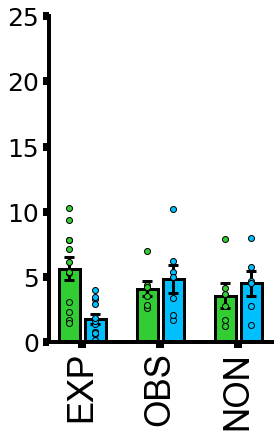

In [583]:
e_color='limegreen'
i_color='deepskyblue'

plt.figure(figsize=(4, 6))

plt.bar(0, np.mean(agg_grid_score_diff_train[0]), color=e_color, yerr=sem(agg_grid_score_diff_train[0]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})
plt.bar(1, np.mean(agg_grid_score_diff_train[1]), color=i_color, yerr=sem(agg_grid_score_diff_train[1]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})

plt.scatter(np.full_like(agg_grid_score_diff_train[0], 0), agg_grid_score_diff_train[0], color=e_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(agg_grid_score_diff_train[1], 1), agg_grid_score_diff_train[1], color=i_color, edgecolor='black', zorder=2)

plt.bar(3, np.mean(obs_grid_score_diff_train[0]), color=e_color, yerr=sem(obs_grid_score_diff_train[0]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})
plt.bar(4, np.mean(obs_grid_score_diff_train[1]), color=i_color, yerr=sem(obs_grid_score_diff_train[1]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})

plt.scatter(np.full_like(obs_grid_score_diff_train[0], 3), obs_grid_score_diff_train[0], color=e_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(obs_grid_score_diff_train[1], 4), obs_grid_score_diff_train[1], color=i_color, edgecolor='black', zorder=2)

plt.bar(6, np.mean(non_grid_score_diff_train[0]), color=e_color, yerr=sem(non_grid_score_diff_train[0]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})
plt.bar(7, np.mean(non_grid_score_diff_train[1]), color=i_color, yerr=sem(non_grid_score_diff_train[1]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})

plt.scatter(np.full_like(non_grid_score_diff_train[0], 6), non_grid_score_diff_train[0], color=e_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(non_grid_score_diff_train[1], 7), non_grid_score_diff_train[1], color=i_color, edgecolor='black', zorder=2)

plt.ylim(bottom=0, top=25)

plt.xticks([0.5, 3.5, 6.5], ['EXP', 'OBS', 'NON'], fontsize=35, fontfamily='Arial', rotation=90)
sns.despine()
plt.savefig('.\\figures\\decoding_training_importance.svg', dpi=300, bbox_inches='tight')

In [546]:
for pair in [agg_grid_score_diff_train, obs_grid_score_diff_train, non_grid_score_diff_train]:
    t, p = stats.ttest_rel(pair[0], pair[1])
    print('t = %f, p = %f' % (t, p))

t = 4.620738, p = 0.000739
t = -0.543690, p = 0.606250
t = -0.815751, p = 0.451738


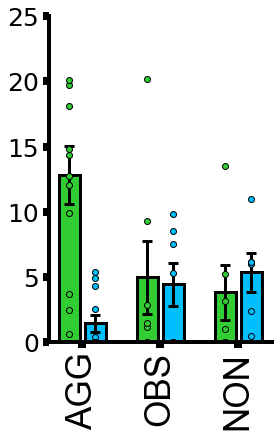

In [582]:
sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

e_color='limegreen'
i_color='deepskyblue'

plt.figure(figsize=(4, 6))

plt.bar(0, np.mean(agg_grid_score_diff_test[0]), color=e_color, yerr=sem(agg_grid_score_diff_test[0]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})
plt.bar(1, np.mean(agg_grid_score_diff_test[1]), color=i_color, yerr=sem(agg_grid_score_diff_test[1]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})

plt.scatter(np.full_like(agg_grid_score_diff_test[0], 0), agg_grid_score_diff_test[0], color=e_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(agg_grid_score_diff_test[1], 1), agg_grid_score_diff_test[1], color=i_color, edgecolor='black', zorder=2)

plt.bar(3, np.mean(obs_grid_score_diff_test[0]), color=e_color, yerr=sem(obs_grid_score_diff_test[0]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})
plt.bar(4, np.mean(obs_grid_score_diff_test[1]), color=i_color, yerr=sem(obs_grid_score_diff_test[1]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})

plt.scatter(np.full_like(obs_grid_score_diff_test[0], 3), obs_grid_score_diff_test[0], color=e_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(obs_grid_score_diff_test[1], 4), obs_grid_score_diff_test[1], color=i_color, edgecolor='black', zorder=2)

plt.bar(6, np.mean(non_grid_score_diff_test[0]), color=e_color, yerr=sem(non_grid_score_diff_test[0]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})
plt.bar(7, np.mean(non_grid_score_diff_test[1]), color=i_color, yerr=sem(non_grid_score_diff_test[1]), edgecolor='black', linewidth=3,
error_kw={'capsize': 5, 'elinewidth': 3, 'capthick': 3})

plt.scatter(np.full_like(non_grid_score_diff_test[0], 6), non_grid_score_diff_test[0], color=e_color, edgecolor='black', zorder=2)
plt.scatter(np.full_like(non_grid_score_diff_test[1], 7), non_grid_score_diff_test[1], color=i_color, edgecolor='black', zorder=2)

plt.ylim(bottom=0, top=25)

plt.xticks([0.5, 3.5, 6.5], ['AGG', 'OBS', 'NON'], fontsize=35, fontfamily='Arial', rotation=90)
sns.despine()
plt.savefig('.\\figures\\decoding_hf_importance.svg', dpi=300, bbox_inches='tight')

In [549]:
ps = []
ts = []
for pair in [agg_grid_score_diff_test, obs_grid_score_diff_test, non_grid_score_diff_test]:
    t, p = stats.ttest_rel(pair[0], pair[1])
    ps.append(p)
    ts.append(t)

_, ps_accepted, _, _ = multipletests(ps, method='fdr_bh')
for i, p in enumerate(ps_accepted):
    print('Comparing %s' % ['AGG', 'OBS', 'NON'][i])
    print('t = %f, p = %f' % (ts[i], p))

Comparing AGG
t = 4.852835, p = 0.001525
Comparing OBS
t = 0.201474, p = 0.846985
Comparing NON
t = -1.003730, p = 0.542373


3. Analyse train->CD1

In [551]:
# compute accuracy differentials
agg_cd1_score_diff = np.zeros((agg_perm_cd1_scores.shape))
agg_cd1_score_diff[:, 0, :] = ((agg_cd1_scores - agg_perm_cd1_scores[:, 0, :]) / agg_cd1_scores) * 100
agg_cd1_score_diff[:, 1, :] = ((agg_cd1_scores - agg_perm_cd1_scores[:, 1, :]) / agg_cd1_scores) * 100
agg_cd1_score_diff = np.where(agg_cd1_score_diff < 0, 0, agg_cd1_score_diff)

agg_late_score_diff = np.zeros((agg_perm_late_scores.shape))
agg_late_score_diff[:, 0, :] = ((agg_late_scores - agg_perm_late_scores[:, 0, :]) / agg_late_scores) * 100
agg_late_score_diff[:, 1, :] = ((agg_late_scores - agg_perm_late_scores[:, 1, :]) / agg_late_scores) * 100
agg_late_score_diff = np.where(agg_late_score_diff < 0, 0, agg_late_score_diff)



In [554]:
data2stat = agg_cd1_score_diff[:, 0, :].copy().T
df = pd.DataFrame({
    'Measurement': data2stat.flatten(),
    'Subject': np.concatenate([np.repeat(i, data2stat.shape[1]) for i in np.arange(12)]),
    'Time': np.concatenate([np.arange(data2stat.shape[1]) for i in np.arange(12)])
})

# Perform mixed linear model
model = MixedLM(df['Measurement'], df[['Time']], groups=df['Subject'])
res1 = model.fit()
print("Time effect for train->HF:", res1.pvalues['Time'])
print('t = %f' % res1.tvalues['Time'])

###

data2stat = agg_cd1_score_diff[:, 1, :].copy().T
df = pd.DataFrame({
    'Measurement': data2stat.flatten(),
    'Subject': np.concatenate([np.repeat(i, data2stat.shape[1]) for i in np.arange(12)]),
    'Time': np.concatenate([np.arange(data2stat.shape[1]) for i in np.arange(12)])
})

print("Time effect for train->HF:", res2.pvalues['Time'])
print('t = %f' % res2.tvalues['Time'])

# Perform mixed linear model
model = MixedLM(df['Measurement'], df[['Time']], groups=df['Subject'])
res2 = model.fit()

_, p, _, _ = multipletests([res1.pvalues['Time'], res2.pvalues['Time']], method='bonferroni')
print(p)


Time effect for train->HF: 0.013788449312215794
t = 2.462728
Time effect for train->HF: 0.2622421305408923
t = 1.121107
[0.0275769  0.52448426]


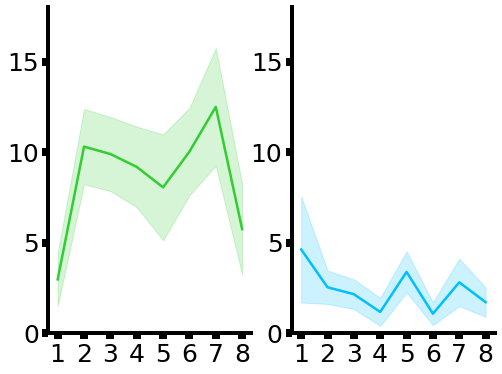

In [503]:
mean_func = np.mean
fig, ax = plt.subplots(1,2, figsize=(8, 6))
ax[0].plot(np.arange(8), mean_func(agg_cd1_score_diff[:, 0, :], axis=1), color='limegreen', label='E')
ax[0].fill_between(np.arange(8), mean_func(agg_cd1_score_diff[:, 0, :], axis=1)+sem(agg_cd1_score_diff[:, 0, :], axis=1), 
mean_func(agg_cd1_score_diff[:, 0, :], axis=1)-sem(agg_cd1_score_diff[:, 0, :], axis=1), color='limegreen', alpha=0.2)
ax[0].set_xticks(np.arange(8))
ax[0].set_xticklabels(np.arange(1, 9))
ax[0].set_ylim(bottom=0, top=18)

ax[1].plot(np.arange(8), mean_func(agg_cd1_score_diff[:, 1, :], axis=1), color='deepskyblue', label='I')
ax[1].fill_between(np.arange(8), mean_func(agg_cd1_score_diff[:, 1, :], axis=1)+sem(agg_cd1_score_diff[:, 1, :], axis=1), 
mean_func(agg_cd1_score_diff[:, 1, :], axis=1)-sem(agg_cd1_score_diff[:, 1, :], axis=1), color='deepskyblue', alpha=0.2)
ax[1].set_xticks(np.arange(8))
ax[1].set_xticklabels(np.arange(1, 9))
ax[1].set_ylim(bottom=0, top=18)

sns.despine()
plt.savefig('.\\figures\\decoding_train-cd1_HF_importance.svg', dpi=300, bbox_inches='tight')